In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('octopus_energy_fb_comments.csv')
df.head()

,Unnamed: 0,fb_comment
0,0,Congratulations Laura
1,1,Rang u as my smart meter ain't working on scre...
2,2,"I just applied switched to Octopus , but can I..."
3,3,What do I need to do to get smart metres...
4,4,Could of phoned me


In [3]:
# def clean_data_small(text):
#     list_data2=[]
#     sentence=text.split(' ')
#     for word in sentence:
#         if not word.startswith('http') \
#            and not word.startswith('@') :
#             list_data2.append(word)
#     return " ".join(list_data2)
# df.fb_comment = df.fb_comment.apply(lambda x: clean_data_small(str(x)))

In [4]:
df.fb_comment.replace("_" , " ", regex=True, inplace = True)
df.fb_comment.replace("^" , " ", regex=True, inplace = True)

In [5]:
df.fb_comment.head()

0                                Congratulations Laura
1     Rang u as my smart meter ain't working on scr...
2     I just applied switched to Octopus , but can ...
3          What do I need to do to get smart metres...
4                                  Could of phoned me 
Name: fb_comment, dtype: object

In [6]:
import string
for punc in string.punctuation:
    if punc == "@": pass
    elif punc == "'":
        df.fb_comment.replace(f"\{punc}", " ", regex=True, inplace = True)
    else:
        try:
            df.fb_comment.replace(f"\{punc}", "", regex=True, inplace = True)
        except:
            pass

In [7]:
df.fb_comment[0]

' Congratulations Laura'

In [8]:
junk_words = "tqvm yessssssssssit youuuuuu nan nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [9]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [10]:
def clean_data(text, small_word_lmt=2, extra_words=junk_words_list):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.lower().split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if word.startswith("@"):
            list_data2.append(word)
        elif not word.startswith('http') \
           and word.isalpha() \
           and len(word)>small_word_lmt \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.fb_comment = df.fb_comment.apply(lambda x: clean_data(x))

In [11]:
df.fb_comment[0]

'congratulations laura'

In [12]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.fb_comment = df.fb_comment.apply(lambda x: word_root(x))  

In [13]:
df.fb_comment[0]

'congratulation laura'

In [14]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.fb_comment.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.fb_comment.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [15]:
filter_size = len(df.fb_comment)/100
filter_size  = 7.5

In [16]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([fb_comment.split() for fb_comment in df.fb_comment])
# Filter only those that occur at least 50 times
bigram_scores = []
while not bigram_scores:
    finder.apply_freq_filter(filter_size)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)
    
    filter_size -= 0.1

In [61]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([fb_comment.split() for fb_comment in df.fb_comment])
# Filter only those that occur at least 50 times
trigram_scores = []
while not trigram_scores:
    finder.apply_freq_filter(filter_size)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)
    filter_size -= 0.1
trigram_scores

[(('meter_reading', 'meter_reading', 'meter_reading'), 15.02221851299496),
 (('wait_smart_meter', 'wait_smart_meter', 'wait_smart_meter'),
  15.02221851299496),
 (('hello_octopus', 'hello_octopus', 'hello_octopus'), 14.682368510110337),
 (('week_ago', 'week_ago', 'week_ago'), 14.682368510110337),
 (('great_company', 'great_company', 'great_company'), 14.378362323220237),
 (('lisa_middleton', 'lisa_middleton', 'lisa_middleton'), 14.378362323220237),
 (('email_send', 'email_send', 'send_email'), 14.111325986828946),
 (('switch_octopus', 'switch_octopus', 'switch_octopus'), 14.103355275720366),
 (('smart_meter_instal', 'smart_meter_instal', 'smart_meter_instal'),
  14.099034110045793),
 (('direct_debit', 'direct_debit', 'direct_debit'), 13.621339076712772),
 (('reply_email', 'reply_email', 'reply_email'), 12.847292830494279),
 (('email_send', 'email_send', 'email_send'), 12.670753395442961),
 (('customer_service', 'customer_service', 'customer_service'),
  11.208437321777925),
 (('octopus

In [18]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [19]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [20]:
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [21]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [22]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

In [23]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 3, axis = 1)][:500]
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 3, axis = 1)][:500]

In [24]:
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [25]:
# bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
# trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [26]:
bigrams

['lisa middleton',
 'direct debit',
 'week ago',
 'customer service',
 'smart meter',
 'meter fit',
 'meter instal',
 'reply email',
 'great company',
 'octopus energy',
 'meter reading',
 'wait smart',
 'send email',
 'email send',
 'hello octopus',
 'switch octopus']

In [27]:
trigrams

['smart meter instal', 'smart meter fit', 'wait smart meter']

In [28]:
replace_ngrams = {}

for i in trigrams:
    replace_ngrams[i] = i.replace(" ","_")
for j in bigrams:
    replace_ngrams[j] = j.replace(" ","_")

In [29]:
for key, value in replace_ngrams.items():
    df.fb_comment.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [30]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.fb_comment.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [31]:
# df.drop(df[df.fb_comment.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [32]:
df_clean = df.fb_comment
df_clean.shape

(768,)

In [33]:
df_clean = df_clean.dropna()
df_clean.shape

(768,)

In [34]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [35]:
from sentence_transformers import SentenceTransformer

In [36]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [37]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [38]:
# embeddings1[embeddings1.argmax()]

In [39]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [40]:
model=SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
embeddings3 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [41]:
model=SentenceTransformer('allenai-specter')
embeddings4 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [42]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)
embeddings3_norm = embeddings3 /  np.linalg.norm(embeddings3, axis=1, keepdims=True)
embeddings4_norm = embeddings4 /  np.linalg.norm(embeddings4, axis=1, keepdims=True)

In [43]:
import umap

In [44]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [45]:
UMAP_bert3 = umap.UMAP(n_components=2).fit_transform(embeddings3)
UMAP_bert3_norm = umap.UMAP(n_components=2).fit_transform(embeddings3_norm)

UMAP_bert4 = umap.UMAP(n_components=2).fit_transform(embeddings4)
UMAP_bert4_norm = umap.UMAP(n_components=2).fit_transform(embeddings4_norm)

In [46]:
from pyclustertend import hopkins

embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
              "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
              "UMAP_bert3" : UMAP_bert3, "UMAP_bert3_norm" : UMAP_bert3_norm, 
              "UMAP_bert4" : UMAP_bert4, "UMAP_bert4_norm" : UMAP_bert4_norm}

embeds = {}

for key, emb in embeddings.items():
    embeds[key] = hopkins(emb,emb.shape[0])

embeds
# embeddings[embeds.index(min(embeds))]
# print(f"the hopkins score for embeddings {i} is : {hs}")

{'UMAP_bert1': 0.06839510208580099,
 'UMAP_bert1_norm': 0.0816521943246372,
 'UMAP_bert2': 0.013453226058924657,
 'UMAP_bert2_norm': 0.15975758947527258,
 'UMAP_bert3': 0.01627091958361818,
 'UMAP_bert3_norm': 0.02140541073543355,
 'UMAP_bert4': 0.07374506450527117,
 'UMAP_bert4_norm': 0.07419665556482467}

In [47]:
best_embed_name = min(embeds, key=embeds.get)
best_model = embeddings[best_embed_name]
best_embed_name

'UMAP_bert2'

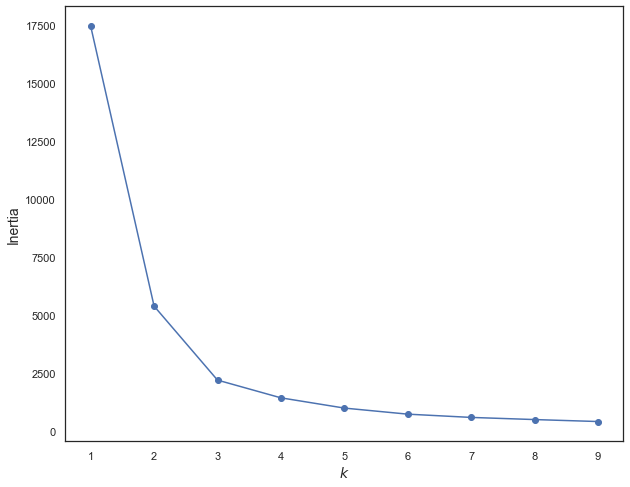

In [48]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [55]:
cluster = KMeans(n_clusters=4, init="k-means++").fit_predict(best_model)

In [56]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = best_model



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Spectral')
    plt.show()

{0: 192, 1: 254, 2: 23, 3: 299}


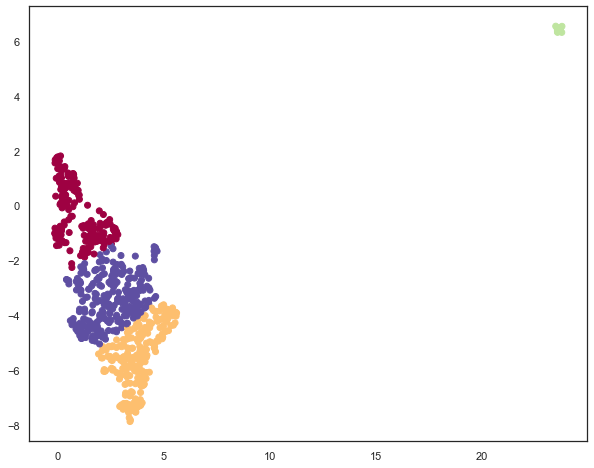

In [57]:
plot()

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [59]:
def cluster_words(cluster = cluster, top_n = 20):
    print("-"*50,best_embed_name,"-"*50)

    docs = pd.DataFrame(df_clean)
    docs["cluster"] = cluster

    labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"fb_comment": " ".join})

    tfidf_vec = TfidfVectorizer()
    try:
        tfidf_mat = tfidfmatrix(labeled_docs.fb_comment, tfidf_vec)
    except: pass

    global most_common
    most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                            for n, col in enumerate(tfidf_mat.T)}).T
#         most_common.index = np.unique(cluster)
    display(most_common)

In [60]:
cluster_words()

-------------------------------------------------- UMAP_bert2 --------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,lisa_middleton,apple,cake,amazing,bake,pie,pink,love,make,news,great,please,ice,jame,chocolate,crumble,rebecca,robert,vegan,bit
1,smart_meter,octopus_energy,octopus,month,hello_octopus,meter,still,email,wait_smart_meter,switch_octopus,smart_meter_instal,customer_service,direct_debit,switch,customer,say,company,bill,please,smart_meter_fit
2,abby,above,absolute,absolutely,accept,accidentally,accolade,account,acknowledge,acknowledgement,acknowledgementthank,acquaintance,action,active,actually,adam,add,address,adequacy,adjust
3,customer_service,email,email_send,reply_email,company,customer,great_company,call,back,still,month,switch,please,answer,good,know,thank,use,reply,try
